In [17]:
%matplotlib inline

import sqlite3
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from Utility import Database as db
from Utility import Tabulate

In [2]:
# def delete_results(problem_name, population_size):
#     db.con.execute(f'''
#         DELETE FROM 
#             result 
#         WHERE ROWID IN  (
#             SELECT 
#                 result.ROWID 
#             FROM 
#                 result 
#             INNER JOIN 
#                 config 
#             ON 
#                 (config.config_id = result.config_id) 
#             WHERE 
#                 config.name="{problem_name}" and
#                 config.population_size={population_size}
#         )
#     ''').fetchall()
    
#     db.con.execute(f'''
#         DELETE FROM 
#             config
#         where
#             config.name="{problem_name}" and
#             config.population_size={population_size}
#     ''')
    
# # delete_results('Rosenbrock', 320)
# # db.save_and_quit()

In [3]:
def plot_epochs_migration_rate_vs_fitness(problem_name, population_size):
    # same y axis
    # get best results for an algorithm table
    algorithms = [
        'Island GA Ring Lattice',
        'Island GA Cell',
        'Island GA Hierarchy',
        'Island GA Caveman',
        'Island GA Rewired Caveman',
        'Island GA Watts Strogatz',
        'Island GA Full'
    ]
    
    fig = plt.figure(figsize=(15,18))
    subplots = fig.subplots((len(algorithms)//2)+1, 2, subplot_kw=dict(projection='3d'),)
    subplots = [item for sublist in subplots for item in sublist]
    
    min_fitness = 10000000000
    max_fitness = -10000000000
    
    for i, alg_name in enumerate(algorithms):
        results = db.con.execute(f'''
            select 
                config.epochs_till_migration,
                config.migration_rate,
                fitness
            from 
                result
            inner join 
                config
            on 
                result.config_id == config.config_id
            where 
                name="{problem_name}" and 
                population_size={population_size} and 
                algorithm="{alg_name}"
        ''').fetchall()

        df = pd.DataFrame(
            results, 
            columns=['Epoch', 'Migration Rate', 'Fitness'])
        df = df.groupby(['Epoch', 'Migration Rate']).mean().reset_index()
        
        ax = subplots[i]
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Migration Rate')
        ax.set_zlabel('Fitness')
        ax.set_title(alg_name)

        ax.plot_trisurf(df['Epoch'], df['Migration Rate'], df['Fitness'])
        
        min_fitness = min(min_fitness, df['Fitness'].min())
        max_fitness = max(max_fitness, df['Fitness'].max())
        
        
    for ax in subplots:
        ax.set_zlim(min_fitness, max_fitness)
    plt.show()

In [4]:
def get_best_results(problem_name, population_size):
    algorithms = [
        'Island GA Ring Lattice',
        'Island GA Cell',
        'Island GA Hierarchy',
        'Island GA Caveman',
        'Island GA Rewired Caveman',
        'Island GA Watts Strogatz',
        'Island GA Full'
    ]
    
    for i, alg_name in enumerate(algorithms):
        results = db.con.execute(f'''
            select 
                config.algorithm, 
                fitness,
                config.migration_rate,
                config.epochs_till_migration
            from 
                result
            inner join 
                config
            on 
                result.config_id == config.config_id
            where 
                name="{problem_name}" and 
                population_size={population_size}
            group by 
                config.algorithm
            having
                result.fitness == min(result.fitness)
            order by 
                result.fitness
        ''').fetchall()
        
    Tabulate.print_table([
            'Algorith', 
            'Fitness', 
            'Migration Rate', 
            'Epochs Per Migraiton'
        ],
        results)


In [5]:
def plot_calculations_fitness(problem_name, population_size):    
    results = db.con.execute(f'''
        select 
            config.algorithm, 
            config.fitness_calculations,
            config.epochs_till_migration,
            config.migration_rate,
            fitness
        from 
            result
        inner join 
            config
        on 
            result.config_id == config.config_id
        where 
            name="{problem_name}" and 
            population_size={population_size}
    ''').fetchall()

    df = pd.DataFrame(
        results, 
        columns=['Algorithm', 'Fitness Calculations', 'Epoch', 'Migration Rate', 'Fitness'])
    
#     print(df.to_string(index=False))
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.set_theme(style="darkgrid")
    sns.lineplot(data=df, x='Fitness Calculations', y='Fitness', hue='Algorithm')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [22]:
def algorithm_best(problem_name, population_size, limit, fitness_calculations):
    algorithms = [
        'Island GA Ring Lattice',
        'Island GA Cell',
        'Island GA Hierarchy',
        'Island GA Caveman',
        'Island GA Rewired Caveman',
        'Island GA Watts Strogatz',
        'Island GA Full'
    ]
    
    for i, alg_name in enumerate(algorithms):
        results = db.con.execute(f'''
            select 
                fitness,
                config.migration_rate,
                config.epochs_till_migration
            from 
                result
            inner join 
                config
            on 
                result.config_id == config.config_id
            where 
                name="{problem_name}" and 
                population_size={population_size} and
                algorithm="{alg_name}" and
                fitness_calculations={fitness_calculations}
        ''').fetchall()
        
        df = pd.DataFrame(
            results, 
            columns=['Fitness', 'Migration Rate', 'Epoch'])
        df = df.groupby(['Epoch', 'Migration Rate']).mean().reset_index()

        
        print(alg_name)
        print(df.nsmallest(limit, 'Fitness'))
        
        print()

## Binary Alpine, 1280

In [7]:
# plot_epochs_migration_rate_vs_fitness('Alpine', 640)

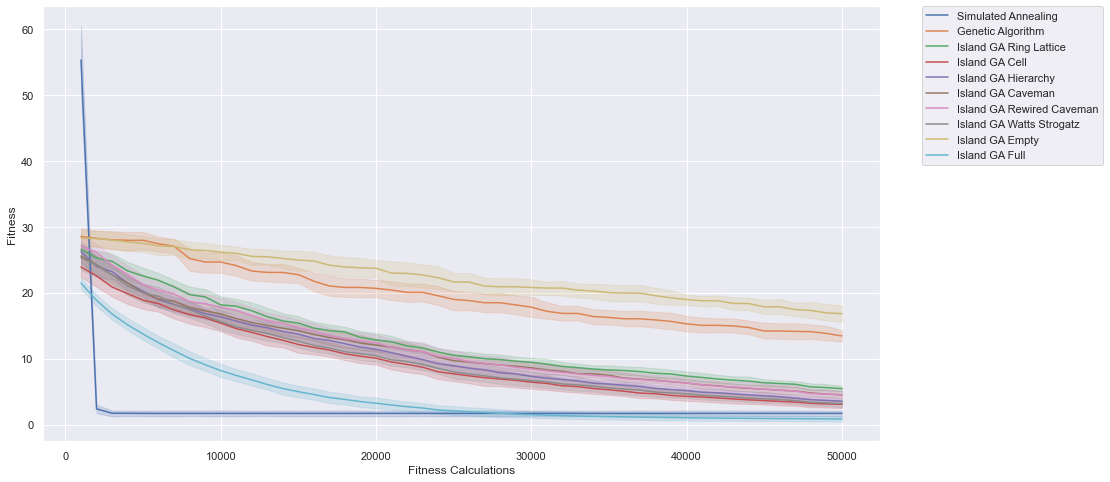

In [8]:
plot_calculations_fitness('Alpine', 1280)

## Rastrigin, 640

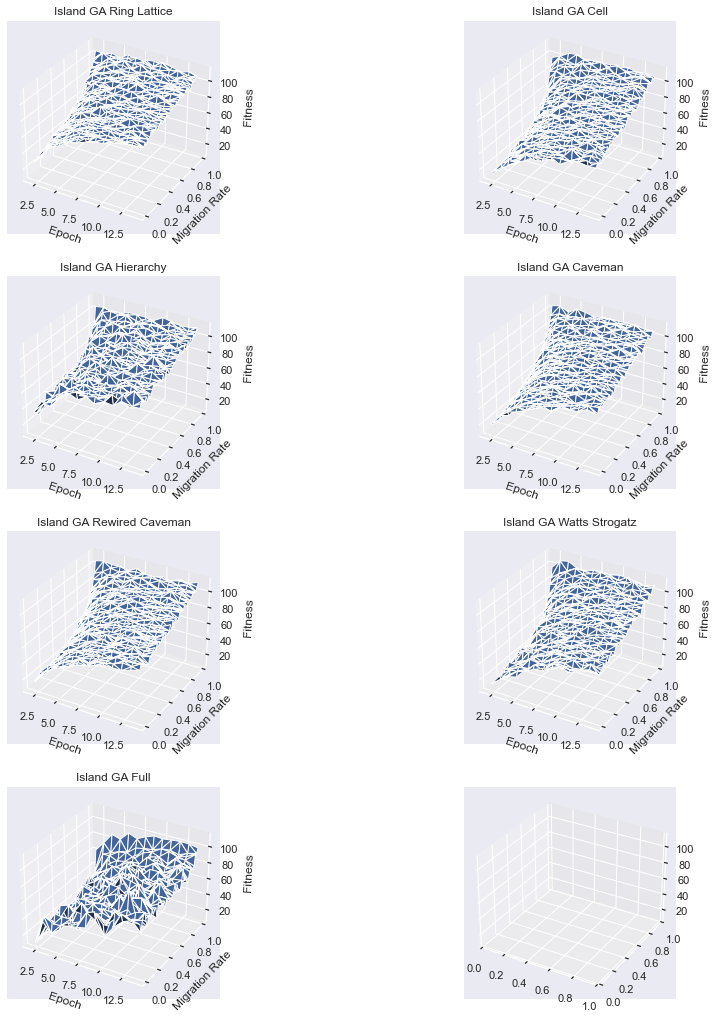

In [9]:
plot_epochs_migration_rate_vs_fitness('Rastrigin', 640)

In [10]:
algorithm_best('Rastrigin', 640, 10)

Island GA Ring Lattice
   Epoch  Migration Rate    Fitness
5      2            0.11  26.092309
4      2            0.09  26.620309
1      2            0.03  27.629178
0      2            0.01  28.293901
3      2            0.07  28.806091
6      2            0.13  29.219877
2      2            0.05  29.850918
7      2            0.15  30.855179
8      2            0.17  30.936575
9      2            0.19  32.970741

Island GA Cell
    Epoch  Migration Rate    Fitness
1       2            0.03  11.758219
3       2            0.07  13.446679
2       2            0.05  13.655508
6       2            0.13  13.824376
5       2            0.11  13.891722
8       2            0.17  13.911939
14      2            0.29  15.126614
4       2            0.09  15.170945
0       2            0.01  15.303354
7       2            0.15  15.402778

Island GA Hierarchy
    Epoch  Migration Rate    Fitness
4       2            0.09  26.542676
3       2            0.07  26.673890
14      2            0.29 

In [11]:
get_best_results('Rastrigin', 640)

Algorith                      Fitness                Migration Rate     Epochs Per Migraiton     
Island GA Full                3.797806204723102      0.03               2                        
Island GA Watts Strogatz      6.307038603587561      0.01               2                        
Island GA Cell                8.372902776923484      0.03               2                        
Island GA Caveman             9.704951750689483      0.09               2                        
Island GA Rewired Caveman     10.723897649090746     0.19               2                        
Island GA Hierarchy           14.795598968767191     0.01               2                        
Island GA Ring Lattice        20.21260455374697      0.11               2                        
Island GA Empty               91.45033249121386      0.01               2                        


## TSP, 320

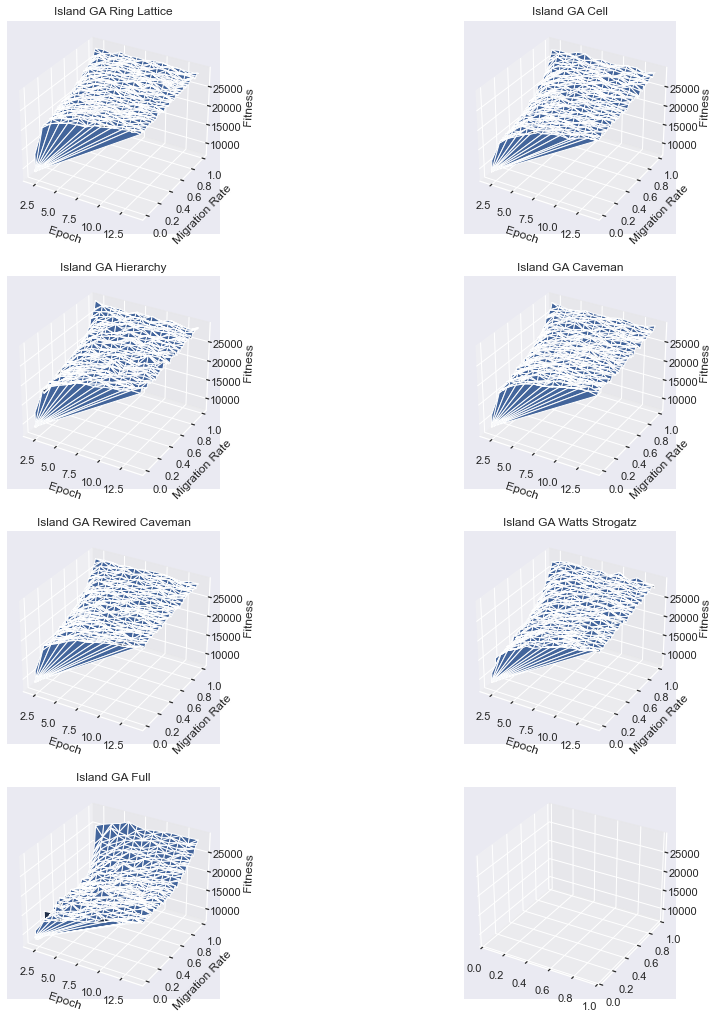

In [12]:
plot_epochs_migration_rate_vs_fitness('TSP', 320)

In [13]:
get_best_results('TSP', 320)

Algorith                      Fitness     Migration Rate     Epochs Per Migraiton     
Island GA Full                7013.0      0.149              2                        
Island GA Cell                7151.0      0.195              2                        
Island GA Hierarchy           7164.0      0.248              2                        
Island GA Rewired Caveman     7188.0      0.169              2                        
Island GA Watts Strogatz      7206.0      0.234              2                        
Island GA Caveman             7329.0      0.247              2                        
Island GA Ring Lattice        7423.0      0.271              2                        
Island GA Empty               8517.0      0.0                2                        
Simulated Annealing           13196.0     0.01               1                        
Genetic Algorithm             29154.0     0.01               1                        


In [14]:
algorithm_best('TSP', 320, 10)

Island GA Ring Lattice
     Epoch  Migration Rate  Fitness
208      2           0.206   8018.2
275      2           0.272   8027.1
285      2           0.282   8031.5
284      2           0.281   8032.4
230      2           0.227   8047.1
209      2           0.207   8054.9
302      2           0.298   8080.1
246      2           0.243   8104.7
291      2           0.288   8105.0
276      2           0.273   8106.6

Island GA Cell
     Epoch  Migration Rate  Fitness
285      2           0.282   7656.5
303      2           0.299   7657.0
284      2           0.281   7661.3
250      2           0.247   7666.5
254      2           0.251   7682.3
246      2           0.243   7693.7
286      2           0.283   7696.2
232      2           0.229   7697.3
244      2           0.241   7702.4
289      2           0.286   7712.0

Island GA Hierarchy
     Epoch  Migration Rate  Fitness
283      2           0.280   7642.6
282      2           0.279   7747.7
271      2           0.268   7761.2
274 

## Rosenbrock, 320

No handles with labels found to put in legend.


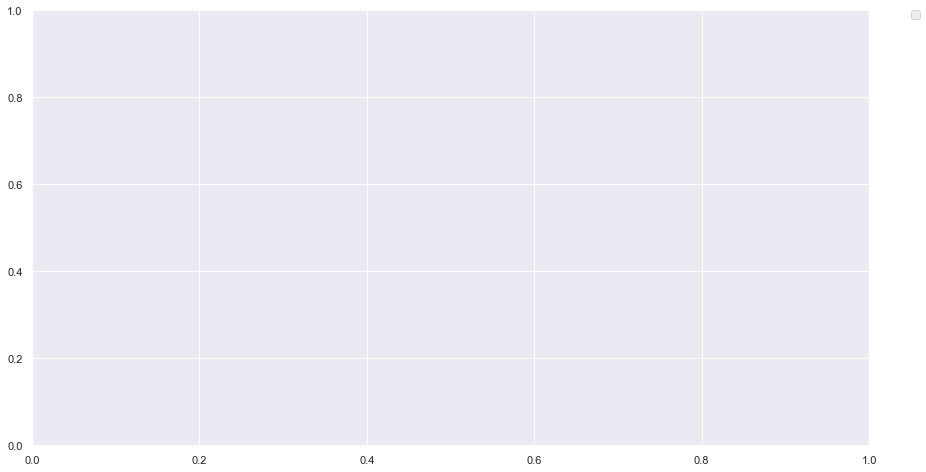

In [15]:
plot_calculations_fitness('Rosenbrock', 320)

In [16]:
algorithm_best('Rosenbrock', 320, 10)

DataError: No numeric types to aggregate

## migration rate test

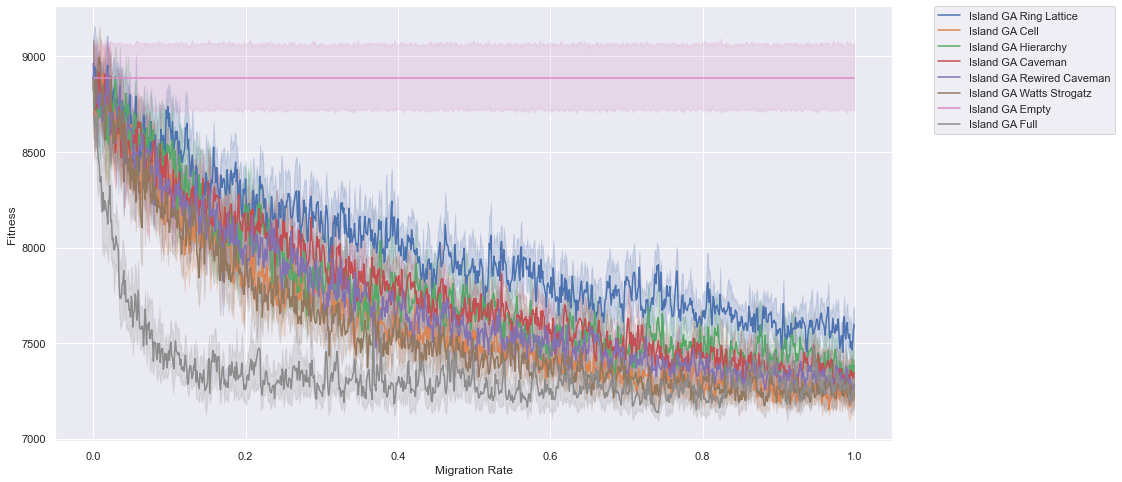

In [20]:
results = db.con.execute('''
    select 
        config.algorithm, 
        config.migration_rate,
        fitness
    from 
        result
    inner join 
        config
    on 
        result.config_id == config.config_id
    where 
        name="TSP" and 
        strand_size = 22 and
        population_size=320 and
        fitness_calculations=10000
''').fetchall()

df = pd.DataFrame(
    results, 
    columns=['Algorithm', 'Migration Rate', 'Fitness'])

#     print(df.to_string(index=False))
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme(style="darkgrid")
sns.lineplot(data=df, x='Migration Rate', y='Fitness', hue='Algorithm')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [23]:
algorithm_best('TSP', 320, 10, 10_000)

Island GA Ring Lattice
     Epoch  Migration Rate  Fitness
984      2           0.984   7451.2
937      2           0.937   7453.8
996      2           0.996   7464.0
904      2           0.904   7466.0
936      2           0.936   7468.3
980      2           0.980   7472.7
909      2           0.909   7474.4
994      2           0.994   7476.1
981      2           0.981   7486.1
903      2           0.903   7494.6

Island GA Cell
     Epoch  Migration Rate  Fitness
966      2           0.966   7150.9
993      2           0.993   7166.4
994      2           0.994   7169.4
957      2           0.957   7185.9
992      2           0.992   7185.9
902      2           0.902   7189.2
967      2           0.967   7189.3
893      2           0.893   7191.9
817      2           0.817   7194.9
924      2           0.924   7195.8

Island GA Hierarchy
     Epoch  Migration Rate  Fitness
990      2           0.990   7294.4
991      2           0.991   7295.4
987      2           0.987   7297.1
979 